In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dydx3 import Client
from dydx3.constants import API_HOST_ROPSTEN 
import ccxt

from utils import *

In [18]:
client = Client(
    host=API_HOST_ROPSTEN,
    api_key_credentials={"key":"6e9c0f7e-e6a5-83c5-aaca-94d5be497e35",
    "secret":"GBGIq_BWvGEP_JeaxZgphHoMvP6nliG1WemrNT9A",
    "passphrase":"pB_GOOCB8OUk9EhDm8Eo"}
)
num_traders = [20460, 9979, 11175, 8502, 6448, 4876, 5008, 4547]
rewards = {}
for epoch in range(8):
    rewards[epoch] = client.private.get_trading_rewards(epoch=epoch).data
    rewards[epoch]['fees'] = rewards[epoch]['fees']['totalFeesPaid']
    rewards[epoch]['openInterest'] = rewards[epoch]['openInterest']['totalAverageOpenInterest']
    rewards[epoch]['stakedDYDX'] = float(rewards[epoch]['stakedDYDX']['totalAverageStakedDYDX'])*num_traders[epoch]
    rewards[epoch]['weight'] = rewards[epoch]['weight']['totalWeight']
    rewards[epoch]['epochStart'] = rewards[epoch]['epochStart'].replace("T15:00:00.000Z", "")
    rewards[epoch]['epochEnd'] = rewards[epoch]['epochEnd'].replace("T15:00:00.000Z", "")
rewards = pd.DataFrame(rewards).T
rewards['date'] = rewards['epochStart']
rewards['numTraders'] = num_traders
rewards.index = rewards['date']
rewards = rewards.drop(['date', 'estimatedRewards'], axis=1)
rewards

,epoch,epochStart,epochEnd,fees,openInterest,stakedDYDX,weight,totalRewards,numTraders
date,,,,,,,,,
2021-08-03,0,2021-08-03,2021-08-31,1071647.87793,127036697.13513679732,0.0,0.56877068887576161983454181,3835616,20460
2021-08-31,1,2021-08-31,2021-09-28,6054641.218010999999999999991,170293617.91203007363,0.0,0.6823323912739626565999994719,3835616,9979
2021-09-28,2,2021-09-28,2021-10-26,83476417.695243,196342688.53197062096,0.0,0.741895675581765164849893574915,3835616,11175
2021-10-26,3,2021-10-26,2021-11-23,70801143.162313,200980039.71586534978,0.0,0.68779956020338361255452404811,3835616,8502
2021-11-23,4,2021-11-23,2021-12-21,52899045.827568,175289739.44953068353,0.0,0.70244453632749194672859742037,3835616,6448
2021-12-21,5,2021-12-21,2022-01-18,2176282.284215,164673930.09013269943,20574299.548275,0.61886415443585213256,3835616,4876
2022-01-18,6,2022-01-18,2022-02-15,1244266.150064,127578968.97075558216,25490720.0,0.62971847021934064227,3835616,5008
2022-02-15,7,2022-02-15,2022-03-15,640498.891893,109582046.72135681526,31056010.0,0.59058456039771119907,3835616,4547


In [19]:
ftx_client = ccxt.ftx()
start = ftx_client.parse8601('2021-09-03T15:00:00:00.000Z')
ohlcv = ftx_client.fetch_ohlcv("DYDX/USD", '1d', since=start, limit=1000)
for i in range(len(ohlcv)):
    ohlcv[i][0] = str(ftx_client.iso8601(ohlcv[i][0])).replace("T00:00:00.000Z", '')
    ohlcv[i] = [ohlcv[i][0], ohlcv[i][4]]
ohlcv = pd.DataFrame(ohlcv, columns=['date', 'close'])
ohlcv.index = ohlcv['date']
ohlcv = ohlcv.drop(['date'], axis=1)
ohlcv = ohlcv.shift(1) # Get prices of the day before
ohlcv


,close
date,
2021-09-08,NaN
2021-09-09,13.149
2021-09-10,13.031
2021-09-11,10.440
2021-09-12,10.932
...,...
2022-03-16,4.503
2022-03-17,4.738
2022-03-18,4.730


In [20]:
df = rewards.join(ohlcv, how='inner')
df = df.iloc[:-1]
df['openInterest'] = df['openInterest'].astype(float).round(3)
df['fees'] = df['fees'].astype(float).round(3)
df['stakedDYDX'] = df['stakedDYDX'].astype(float).round(3)
df['weight'] = df['weight'].astype(float).round(3)
df['totalRewards'] = df['totalRewards'].astype(float)
df = df.round(decimals=3); df

,epoch,epochStart,epochEnd,fees,openInterest,stakedDYDX,weight,totalRewards,numTraders,close
date,,,,,,,,,,
2021-09-28,2,2021-09-28,2021-10-26,8.347642e+07,1.963427e+08,0.000000e+00,0.742,3835616.0,11175,20.972
2021-10-26,3,2021-10-26,2021-11-23,7.080114e+07,2.009800e+08,0.000000e+00,0.688,3835616.0,8502,18.849
2021-11-23,4,2021-11-23,2021-12-21,5.289905e+07,1.752897e+08,0.000000e+00,0.702,3835616.0,6448,14.181
2021-12-21,5,2021-12-21,2022-01-18,2.176282e+06,1.646739e+08,2.057430e+07,0.619,3835616.0,4876,7.398
2022-01-18,6,2022-01-18,2022-02-15,1.244266e+06,1.275790e+08,2.549072e+07,0.630,3835616.0,5008,7.415


In [21]:
df.to_csv('./data/historical.csv')

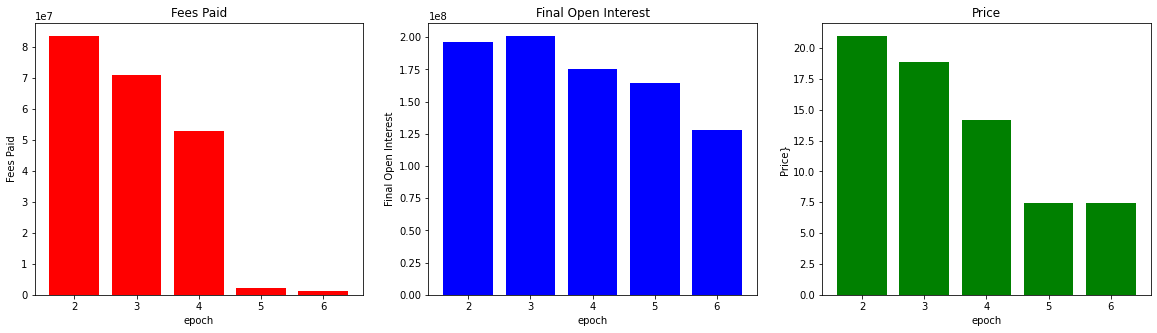

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].bar(df['epoch'], df['fees'], color='red')
axs[0].set_title('Fees Paid')
axs[0].set_ylabel('Fees Paid')
axs[0].set_xlabel('epoch')
axs[1].bar(df['epoch'], df['openInterest'], color='blue')
axs[1].set_title('Final Open Interest')
axs[1].set_ylabel('Final Open Interest')
axs[1].set_xlabel('epoch')
axs[2].bar(df['epoch'], df['close'], color='green')
axs[2].set_title('Price')
axs[2].set_ylabel('Price}')
axs[2].set_xlabel('epoch')

plt.show()

In [23]:
# TODO: Add whales and update function call
results = dict()
for i in range(df.shape[0]):
    row = df.iloc[i]
    epoch = row['epoch']
    if int(epoch) <= 4:
        results[epoch] = find_equilibrium(row['openInterest'], n=row['numTraders'], R=row['totalRewards'], p=row['close'], alpha=.01, num_whales=10, whale_alpha=100)
    else:
        results[epoch] = find_equilibrium_stk(row['openInterest'], G=row['stakedDYDX'], n=row['numTraders'], R=row['totalRewards'], p=row['close'], alpha=.01, num_whales=10, whale_alpha=100)

df['expected'] = [sum(results[epoch][1]) for epoch in results] # sum of fees
df

,epoch,epochStart,epochEnd,fees,openInterest,stakedDYDX,weight,totalRewards,numTraders,close,expected
date,,,,,,,,,,,
2021-09-28,2,2021-09-28,2021-10-26,8.347642e+07,1.963427e+08,0.000000e+00,0.742,3835616.0,11175,20.972,5.626445e+07
2021-10-26,3,2021-10-26,2021-11-23,7.080114e+07,2.009800e+08,0.000000e+00,0.688,3835616.0,8502,18.849,5.055074e+07
2021-11-23,4,2021-11-23,2021-12-21,5.289905e+07,1.752897e+08,0.000000e+00,0.702,3835616.0,6448,14.181,3.799857e+07
2021-12-21,5,2021-12-21,2022-01-18,2.176282e+06,1.646739e+08,2.057430e+07,0.619,3835616.0,4876,7.398,1.889106e+07
2022-01-18,6,2022-01-18,2022-02-15,1.244266e+06,1.275790e+08,2.549072e+07,0.630,3835616.0,5008,7.415,1.894654e+07


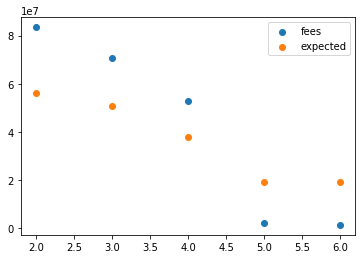

In [24]:
plt.scatter(df['epoch'], df['fees'], label='fees')
plt.scatter(df['epoch'], df['expected'], label='expected')
plt.legend()
plt.show()